In [81]:
import pandas as pd
import seaborn as sns
import os
import wrangle_zillow as w
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, pearsonr
from sklearn.model_selection import train_test_split
from env import get_connection

# Wrangle

In [2]:
df = w.acquire_zillow()
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,781532,12095076,1.0,NaN,NaN,3.0,4.0,NaN,9.0,3.0,...,6.037461e+13,-0.001011,2017-01-01,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN


In [3]:
df = df.rename(columns={'bedroomcnt': 'bedrooms', 'bathroomcnt': 'bathrooms',
                            'calculatedfinishedsquarefeet': 'square_ft', 
                            'taxvaluedollarcnt': 'tax_value', 'yearbuilt': 'year',
                            'taxamount':'tax_amount', 'fips': 'county', 'propertylandusetypeid': 'property_type',
                            'transactiondate': 'transaction_date'})

In [4]:
df['county'] = df['county'].map({6037: 'Los Angeles', 6059: 'Orange', 6111: 'Ventura'})

In [30]:
w.get_continuous_feats(df)

['id',
 'parcelid',
 'bathrooms',
 'calculatedbathnbr',
 'square_ft',
 'finishedsquarefeet12',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'rawcensustractandblock',
 'regionidcity',
 'regionidzip',
 'year',
 'structuretaxvaluedollarcnt',
 'tax_value',
 'landtaxvaluedollarcnt',
 'tax_amount',
 'censustractandblock',
 'logerror']

In [53]:
#bin data
bin_bound = [0, 1.9, 2.9, 3.9, 4.9, 5.9, 18]

bin_labels = ['0_1.5', '2_2.5', '3_3.5', '4_4.5', '5_5.5', '18_plus']

df['bathrooms_bin'] = pd.cut(df['bathrooms'], bins = bin_bound, labels = bin_labels)


bin_bound = [0, 1.9, 2.9, 3.9, 4.9, 5.9, 6.9, 14]

bin_labels = [1, 2, 3, 4, 5, 6, 14]

df['bedrooms_bin'] = pd.cut(df['bedrooms'], bins = bin_bound, labels = bin_labels)


bin_bound = [0, 1000, 1500, 2000, 2500, 3000, 3500, 21929]

bin_labels = [1000, 1500, 2000, 2500, 3000, 3500, 21929]

df['square_ft_bin'] = pd.cut(df['square_ft'], bins = bin_bound, labels = bin_labels)


bin_bound = [0, 1959, 1969, 1979, 1989, 1999, 2009, 2020 ]

bin_labels = [1950, 1960, 1970, 1980, 1990, 2000, 2010]

df['decade'] = pd.cut(df['year'], bins = bin_bound, labels = bin_labels)

In [6]:
df = w.handle_missing_values(df, .75, .75)

In [7]:
train, val, test = w.split_data(df)
train.shape, val.shape, test.shape

((29259, 33), (12541, 33), (10450, 33))

In [54]:
numericals = ['logerror', 'year', 'square_ft', 'bedrooms', 'bathrooms']
categoricals = ['county' ]
explore_cols = numericals + categoricals

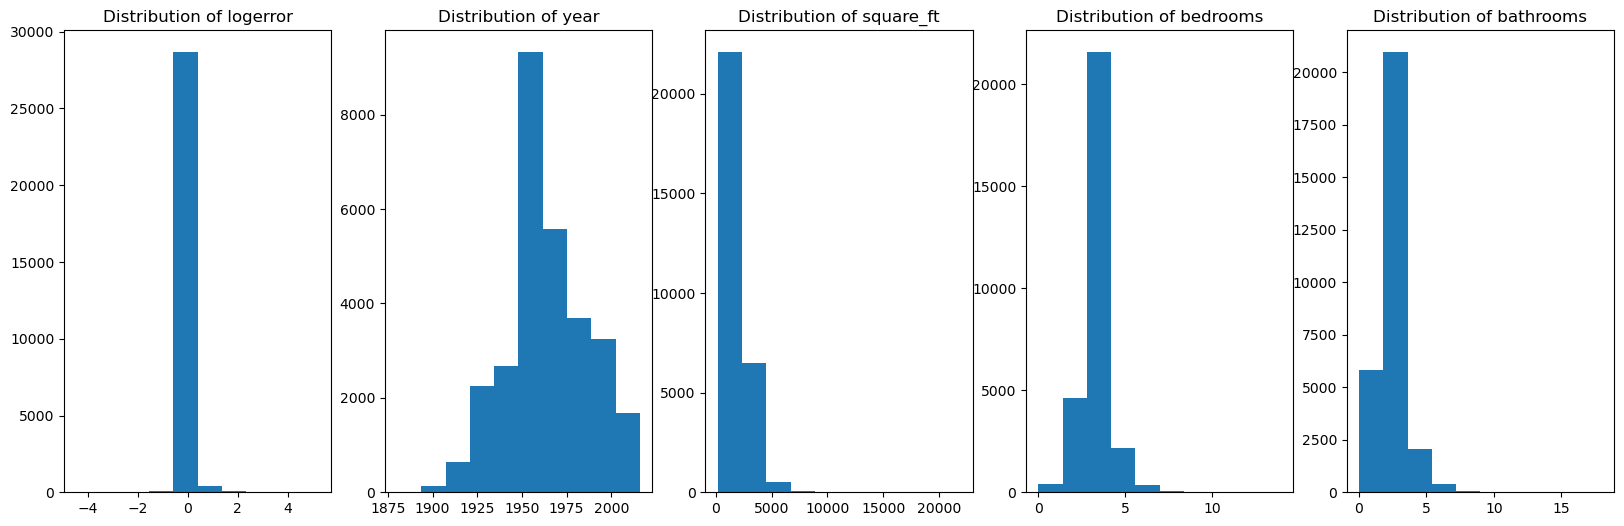

In [32]:
fig, axs = plt.subplots(1,5, figsize=(20,6))
for col, ax in zip(numericals, axs):
    ax.hist(train[col])
    ax.set_title(f'Distribution of {col}')
plt.show()

# Exploratory Analysis

I am looking for features that have similarities based on the logerror. Does the number of bedroooms in bins have a relationship with the logerror?

Does the county the properties are in also have a relationship with the logerror?

Does square ft have a relationship with the logerror?

I have to bin these features to see if a particular group have similarities

# Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

H0: There is no difference in logerror based off county
    
Ha: There is a difference in logerror based off county

<Axes: xlabel='county', ylabel='logerror'>

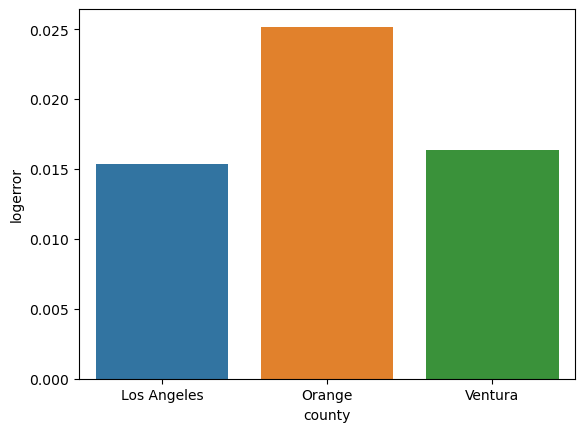

In [73]:
sns.barplot(data = train, x = 'county', y = 'logerror', errorbar = None)

# Does the logerror change across the number of bedrooms?

H0: There is no relationship in logerror and bedrooms
    
Ha: There is a relationship in logerror and bedrooms

<Axes: xlabel='bedrooms', ylabel='logerror'>

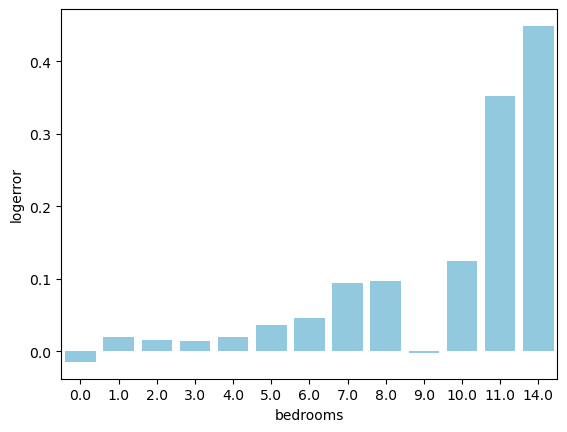

In [88]:
sns.barplot(data = train, x = 'bedrooms', y = 'logerror', errorbar = None, color = 'skyblue')

In [86]:
r, p = pearsonr(df.bedrooms, df.logerror)

a = .5

if p < a:
    
    print(f'We reject the null hypothesis with r={r}, and p={p}')

else:
    
    print(f'We fail to reject the null hypothesis with r={r}, and p={p}')

We reject the null hypothesis with r=0.03958636946638218, and p=1.40262372017308e-19


## Conclusion: Seems like the increase in bedrooms results in increase in logerror except for 9 bedrooms which has the best logerror.

---

# Does the logerror change across the number of bathrooms?

H0: There is no relationship in logerror and bathrooms
    
Ha: There is a relationship in logerror and bathrooms

<Axes: xlabel='bathrooms', ylabel='logerror'>

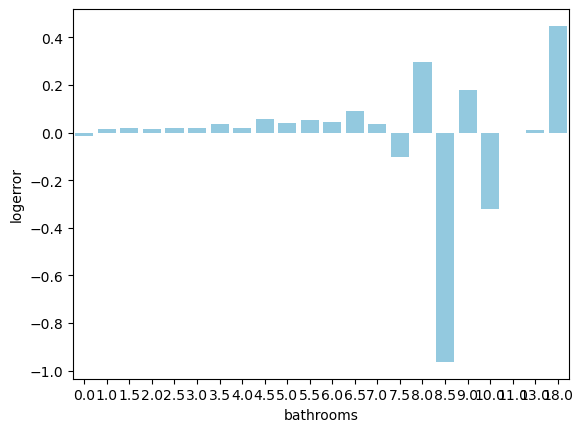

In [78]:
sns.barplot(data=train, x='bathrooms', y='logerror', errorbar = None, color = 'skyblue')

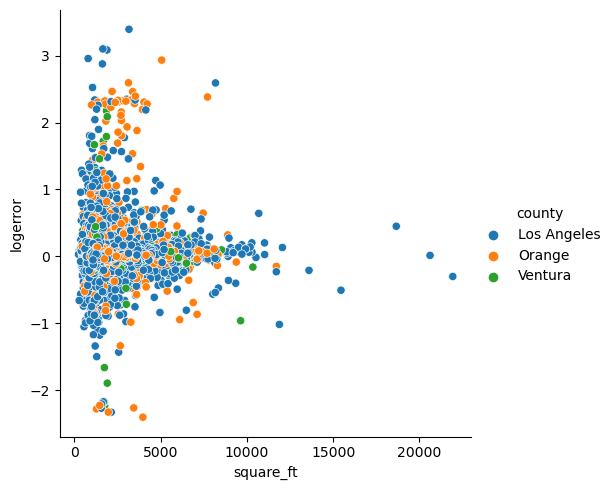

In [103]:
sns.relplot(data = train, x = 'square_ft', y = 'logerror', hue = 'county')

<Axes: xlabel='year', ylabel='logerror'>

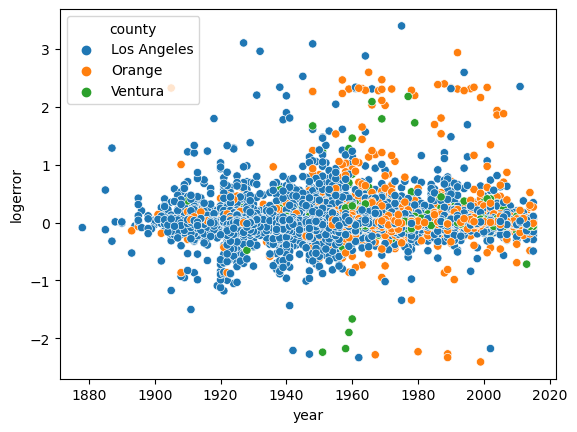

In [102]:
sns.scatterplot(data=train, x='year', y='logerror', hue = 'county')

In [92]:
train, val, test = w.wrangle_zillow()

Shape of Data: 
(52319, 68)
Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52319 entries, 0 to 52318
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            52319 non-null  int64  
 1   parcelid                      52319 non-null  int64  
 2   airconditioningtypeid         13615 non-null  float64
 3   architecturalstyletypeid      70 non-null     float64
 4   basementsqft                  47 non-null     float64
 5   bathroomcnt                   52319 non-null  float64
 6   bedroomcnt                    52319 non-null  float64
 7   buildingclasstypeid           0 non-null      float64
 8   buildingqualitytypeid         33654 non-null  float64
 9   calculatedbathnbr             52184 non-null  float64
 10  decktypeid                    389 non-null    float64
 11  finishedfloor1squarefeet      4371 non-null   float64
 12  calculatedfinishedsquaref

|                           |   count |   unique | top                       |   freq |
|:--------------------------|--------:|---------:|:--------------------------|-------:|
| propertycountylandusecode |   52319 |       26 | 0100                      |  26713 |
| propertyzoningdesc        |   33761 |     1286 | LAR1                      |   6480 |
| taxdelinquencyflag        |    2068 |        1 | Y                         |   2068 |
| transactiondate           |   52319 |      257 | 2017-06-30                |    809 |
| airconditioningdesc       |   13615 |        4 | Central                   |  11873 |
| architecturalstyledesc    |      70 |        5 | Contemporary              |     62 |
| heatingorsystemdesc       |   33849 |        9 | Central                   |  20689 |
| propertylandusedesc       |   52319 |        1 | Single Family Residential |  52319 |
| storydesc                 |      47 |        1 | Basement                  |     47 |
| typeconstructiondesc      |   

In [93]:
train.head()

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,rawcensustractandblock_scaled,regionidcity_scaled,regionidzip_scaled,yearbuilt_scaled,structuretaxvaluedollarcnt_scaled,taxvaluedollarcnt_scaled,landtaxvaluedollarcnt_scaled,taxamount_scaled,censustractandblock_scaled,logerror_scaled
43549,2242446,11887287,5.0,4.0,5.0,4452.0,4452.0,6037.0,5.0,34122603.0,...,0.004910,0.110740,0.001027,0.722628,0.113301,0.058806,0.037722,0.055825,0.000009,0.410284
6685,362354,11640301,4.0,5.0,4.0,3003.0,3003.0,6037.0,4.0,34097434.0,...,0.008111,0.017549,0.000342,0.503650,0.035413,0.024245,0.017667,0.063453,0.000014,0.435440
46076,2741162,14389212,3.0,4.0,3.0,2826.0,2826.0,6059.0,3.0,33581407.0,...,0.296872,0.055886,0.003257,0.729927,0.023095,0.006961,0.002650,0.005838,0.000519,0.420404
30376,1831326,14090302,2.0,3.0,2.0,1391.0,1391.0,6059.0,2.0,33761014.0,...,0.297651,0.079603,0.003319,0.635036,0.009251,0.012291,0.010584,0.012153,0.000520,0.439927
22857,1391795,11702419,1.0,2.0,1.0,1064.0,1064.0,6037.0,1.0,34002389.0,...,0.001776,0.022785,0.000201,0.226277,0.004535,0.002277,0.001430,0.002338,0.000003,0.384292


In [94]:
train = train.rename(columns={'bedroomcnt': 'bedrooms', 'bathroomcnt': 'bathrooms',
                            'calculatedfinishedsquarefeet': 'square_ft', 
                            'taxvaluedollarcnt': 'tax_value', 'yearbuilt': 'year',
                            'taxamount':'tax_amount', 'fips': 'county', 'propertylandusetypeid': 'property_type',
                            'transactiondate': 'transaction_date'})

In [95]:
train['county'] = train['county'].map({6037: 'Los Angeles', 6059: 'Orange', 6111: 'Ventura'})

In [96]:
#bin data
bin_bound = [0, 1.9, 2.9, 3.9, 4.9, 5.9, 18]

bin_labels = ['0_1.5', '2_2.5', '3_3.5', '4_4.5', '5_5.5', '18_plus']

train['bathrooms_bin'] = pd.cut(train['bathrooms'], bins = bin_bound, labels = bin_labels)


bin_bound = [0, 1.9, 2.9, 3.9, 4.9, 5.9, 6.9, 14]

bin_labels = [1, 2, 3, 4, 5, 6, 14]

train['bedrooms_bin'] = pd.cut(train['bedrooms'], bins = bin_bound, labels = bin_labels)


bin_bound = [0, 1000, 1500, 2000, 2500, 3000, 3500, 21929]

bin_labels = [1000, 1500, 2000, 2500, 3000, 3500, 21929]

train['square_ft_bin'] = pd.cut(train['square_ft'], bins = bin_bound, labels = bin_labels)


bin_bound = [0, 1959, 1969, 1979, 1989, 1999, 2009, 2020 ]

bin_labels = [1950, 1960, 1970, 1980, 1990, 2000, 2010]

train['decade'] = pd.cut(train['year'], bins = bin_bound, labels = bin_labels)

<Axes: xlabel='bedrooms', ylabel='logerror'>

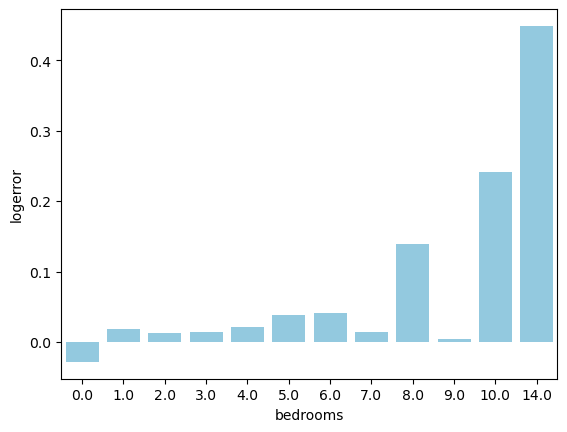

In [101]:
sns.barplot(data = train, x = 'bedrooms', y = 'logerror', errorbar = None, color = 'skyblue')